#---------------------------------------------------------------------------------------------------#

<h2>初期設定</h2>

<h3>1.各種ライブラリのインポート</h3>

In [1]:
import sys
import os
import gc
import math
import itertools
import shutil
import pickle
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline

<h3>2.whale_call_packageディレクトリを格納している絶対パスを記述.</h3>
windows,macでそれぞれ用意しているが不要な方はコメントアウト

In [2]:
#windows
sys.path.append("C:/Users/tomoaki/Desktop/python")

#mac
sys.path.append("/Users/nakahigashikazuo3/Desktop")

<h3>3.whale_call_packageをインポート</h3>

In [3]:
from whale_call_package import whale_call as wh
from whale_call_package import parameter_setting as para

In [4]:
#OBSナンバーを選択
obs = '1805_2020'

<h3>4.作業ディレクトリ、データが格納されているディレクトリを記述。</h3>不要な方をコメントアウト

In [5]:
#windows
preworkdirectory=f'D:/whale/data/WhaleCallField/{obs}'
datadirectory=f'D:/whale/data/origindata/{obs}'

#mac
preworkdirectory=f'/Volumes/LaCie/WhaleCallField/{obs}'
datadirectory=f'/Volumes/LaCie/JS18a/data/{obs}'

<h3>5.パラメータ変更用に作業ディレクトリ下にカレントディレクトリを設定する</h3>

In [6]:
#whale_call_package内のparameter_setting.pyを確認
currentdirectory = '5'
parameter_number = '2'

In [7]:
workdirectory=preworkdirectory+'/'+currentdirectory
whale = wh.SetField(workdirectory=workdirectory, datadirectory=datadirectory)
whale.make_directory()
filelist = whale.get_wavfilelist()

<h3>6.処理を行うwavファイルを指定する場合以下を実行する。</h3>不要ならば全てコメントアウト

<h4>1．任意で指定する。</h4>

In [8]:
#filelist = whale.pick_wavfilelist(filelist=filelist, month=["1904"])
#"1808", "1809", "1810", "1811", "1812", "1901", , "1903", "1904","1905","1906","1907"

<h4>2．ランダムで指定する。</h4>

In [9]:
#filelist = whale.random_pick_wavfilelist(filelist=filelist, pick_num=5)

<h4>3.不要なファイルを削除する。</h4>

In [10]:
filelist = whale.del_wavfile(filelist=filelist, del_list=['180725','180726'])

取得したファイル一覧

In [11]:
filelist

['D:/whale/data/origindata/1805_2020\\180727-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180728-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180729-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180730-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180731-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180801-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180802-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180803-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180804-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180805-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180806-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180807-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180808-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180809-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180810-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180811-000000.wav',
 'D:/whale/data/origindata/1805_2020\\180812-000000.wav',
 'D:/whale/dat

In [12]:
#各パラメータセッティング
sr, n_fft, hop_length, fmin, fmax, fpass, fstop, gpass, gstop, num_train, num_guard, rate_fa = para.para(parameter_number)

In [13]:
#各パラメータのログ出力
para.make_parameter_log(workdirectory=workdirectory, sr=sr, n_fft=n_fft, fmin=fmin, fmax=fmax, fpass=fpass, fstop=fstop, gpass=gpass, gstop=gstop, num_train=num_train, num_guard=num_guard, rate_fa=rate_fa)

<h3>7.各処理の実行有無を決定</h3>

In [14]:
#Trueで実行する

#単日検証用
oneday_flag=False
#cfarの実行
cfar_flag=False
#スペクトログラム画像の生成
ms_flag=False
#鳴音を基に各種グラフの作成
call_graph_flag = False
#CNN用未学習画像を0ディレクトリにコピー
noise_make_flag = False
#学習
sentering_flag = False
#テスト
test_flag = False
#モデルを使用して画像を分類する
sep_fig_flag = False
#分類後画像の情報を保存する
save_calls = False
#中心周波数を抽出
centroid_flag = False
#IPIを抽出
ipi_flag = False
#クラスタリングの実行
clustering = False
cluster_fig = False
#クラスタリングで分類したものの中心周波数を抽出
cent_sep_flag = False

#---------------------------------------------------------------------------------------------------#

<h2>CFARに関する処理</h2>

<h3>1.初期設定</h3>

In [15]:
cfar = wh.Cfar(workdirectory=workdirectory, datadirectory=datadirectory, sr=sr, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax, fpass=fpass, fstop=fstop, gpass=gpass, gstop=gstop, num_train=num_train, num_guard=num_guard, rate_fa=rate_fa)

#---------------------------------------------------------------------------------------------------#

<h3>2.+単日検証用の処理</h3>

In [16]:
handle_day = '190215' #yymmdd.日毎のファイル名

In [17]:
if oneday_flag:
    target_file = [i for i in filelist if f"{handle_day}" in i]
    name = cfar.make_cfar_dir(i=target_file[0])
    y, sr = cfar.get_wav(file=target_file[0])
    data = cfar.bandpass(y)
    peak_idx = cfar.run_cfar(data, name)
    cfar.make_split_wavfile(time=3, peak_idx=peak_idx, name=name, data=y)

    with open(f'{workdirectory}/cfar/pick_list.txt','r',encoding='utf-8') as f:
        lines = f.readlines()
        lines.pop(-1)
    with open(f'{workdirectory}/cfar/pick_list.txt','w',encoding='utf-8') as f:
        for line in lines:
            f.write(line)

グラフの詳細についてはwhale_call_packeage内のCfarクラス、mark_calls_one_dayを確認する

In [18]:
if oneday_flag:
    cfar.mark_calls_one_day(handle_day=handle_day, filelist=filelist)

#---------------------------------------------------------------------------------------------------#

<h3>3.+cfar処理</h3>

cfar処理を実行し、検出した部分を中心にn秒に分割したwaveファイルを作成する.nを変更する場合はtimeを変更.n秒データを出力しない場合にはmake_split_wavefileをコメントアウトする

In [19]:
if cfar_flag:
    for i in filelist:
        name = cfar.make_cfar_dir(i)
        y, srt = cfar.get_wav(i)
        data = cfar.bandpass(y)
        peak_idx = cfar.run_cfar(data=data, name=name) #CFARを実行し、検出した時間と個数を各日付で返し、指定したファイルのリストを出力。
        cfar.make_split_wavfile(time=3, peak_idx=peak_idx, name=name, data=y) #n秒のwavファイルを出力

#---------------------------------------------------------------------------------------------------#

<h2>スペクトログラム作成</h2>

<h3>1.初期設定</h3>

In [20]:
spec = wh.MakeSpectrogram(workdirectory=workdirectory, datadirectory=datadirectory, sr=sr, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax, fpass=fpass, fstop=fstop, gpass=gpass, gstop=gstop, num_train=num_train, num_guard=num_guard, rate_fa=rate_fa)

<h3>2.+単日検証用</h3>

n秒のwaveファイルが存在しないと動作しない

In [21]:
if oneday_flag:
    data, sr = librosa.audio.load(f'{workdirectory}/cfar/{handle_day}/split/{handle_day}_001009.wav', sr=sr) 

In [22]:
if oneday_flag:
    separate_spec = 24
    ym = data.copy()
    dx_data=np.array(ym[0:int(len(ym)/separate_spec)])

In [23]:
if oneday_flag:
    c = np.abs(librosa.stft(data,n_fft=n_fft,hop_length=hop_length,win_length=n_fft,window='hann'))
    C, phase = librosa.magphase(c)
    Cdb = librosa.amplitude_to_db(np.abs(C), ref=np.max)
    plt.figure(figsize=[12, 8])
    librosa.display.specshow(data=Cdb, sr=sr,fmin=fmin, fmax=fmax, x_axis='time', y_axis='hz')
    plt.ylim(10, 40)
    plt.show()

In [24]:
if oneday_flag:
    s = pd.DataFrame(C.flatten())
    s.hist(bins=20, range=(s.min().values[0],s.quantile(0.9).values[0]) )

In [25]:
if oneday_flag:
    spec.make_sep_spec(ym, separate_spec)

#---------------------------------------------------------------------------------------------------#

<h3>3.+n秒画像作成</h3>

In [26]:
if ms_flag:
    picked = spec.get_sp_wav(filelist=filelist)

In [27]:
if ms_flag:
    picked

In [28]:
if ms_flag:
    plt.figure(figsize=[12, 12])
    for i in picked:
        spec.make_sp_spec_all(day=i)
        gc.collect()

#---------------------------------------------------------------------------------------------------#

<h2>Callをグラフで表示</h2>

全て実行するとワークディレクトリに各種グラフが生成される。

In [29]:
%matplotlib inline
#分割数。1時間ごとならsp_time=24,sp_num=分割する時間の秒数*200。１時間なら3600*200
split_time = 24
split_num = 720000
time = 'hour'

#各日の最初の要素を１つ後の要素と同じにする(1でTrue)
first_split = 0

#読み込むpeaktextの種類と保存するディレクトリ名を決定する
peak_file = 'peak.txt'
dir_name = 'day_count'

In [30]:
if call_graph_flag:
    makecallgraph = wh.MakeCallGraph(workdirectory=workdirectory, datadirectory=datadirectory, peak_file=peak_file, dir_name=dir_name)
    max_day_call = makecallgraph.get_max_call_num(filelist)
    months, mean_list, month_name_list = makecallgraph.make_months_list(filelist=filelist)

In [31]:
if call_graph_flag:
    max_per_hour = []
    peak_num_per_day = []
    max_mean = []
    max_mean_per = []
    month_peaks = []
    for i in range(len(months)):
        peakn_hour, mean, mean_per, month_peak_ave, mean_list, peak_num_for_bar = makecallgraph.cal_graph_data(write_setting=i, filelist=filelist, days=months[i][1], month=months[i][0], split_time=split_time, split_num=split_num, time=time, first_split=first_split, mean_list=mean_list)
        max_per_hour.append(peakn_hour)
        max_mean_per.append(mean_per)
        month_peaks.append(month_peak_ave)
        peak_num_per_day.append(peak_num_for_bar)
        max_mean.append(mean)
    max_hour_call = max(list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(max_per_hour)))))
    max_mean_per_call_list = []
    max_mean_call_list = []
    for i in max_mean_per:
        max_mean_per_call_list.append(max(i))
    max_mean_per_call = max(max_mean_per_call_list)

    for i in max_mean:
        max_mean_call_list.append(max(i))
    max_mean_call = max(max_mean_call_list)

    mean_list = [[[] for j in range(24)] for i in range(len(months))]

In [32]:
if call_graph_flag:
    for i in range(len(months)):
        makecallgraph.detect_call_make_glaph(write_setting=i,filelist=filelist, days=months[i][1], month=months[i][0], split_time=split_time, split_num=split_num, time=time, first_split=first_split, mean_list=mean_list,max_hour_call=max_hour_call,max_mean_call=max_mean_call,max_mean_per_call=max_mean_per_call)

In [33]:
if call_graph_flag:
    makecallgraph.make_month_call_num(months=months, month_peak_ave=month_peaks, first_split=first_split, time=time, filelist=filelist, peak_num_per_day=peak_num_per_day, max_day_call=max_day_call)

In [34]:
if call_graph_flag:
    makecallgraph.call_num_per_hour(mean_list=mean_list, month_name_list=month_name_list, time=time, first_split=first_split, max_hour_call=max_hour_call)

#---------------------------------------------------------------------------------------------------#

<h2>CNNでノイズ、センタリングを除去するためのモデルを作成する</h2>

In [35]:
# 学習率
learning_rate = 1e-3
# エポック
epochs = 20
# バッチサイズ
batch_size = 256
#画像サイズ
image_size =128

dir_list = ['sentering', 'noise', 'call', 'n_call']

In [36]:
cnn = wh.Cnn(workdirectory=workdirectory, datadirectory=datadirectory, sr=sr, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax, fpass=fpass, fstop=fstop, gpass=gpass, gstop=gstop, num_train=num_train, num_guard=num_guard, rate_fa=rate_fa)

In [37]:
if noise_make_flag:
    cnn.resize_fig(picked=picked)

In [38]:
#各日から標本を抽出する
if noise_make_flag:
    cnn.prepare_cnn(sr=sr, dir_list=dir_list)

In [39]:
#抽出した画像をテキストファイルにメモする
if noise_make_flag:
    cnn.set_call_list()

学習させたいデータをそれぞれ０から移動させる

In [40]:
train_dir, val_dir, backup_dir = cnn.dir_set(dir_list=dir_list)

In [41]:
train_dir, val_dir, backup_dir

('D:/whale/data/WhaleCallField/1805_2020/5/cfar/all/e_noise',
 'D:/whale/data/WhaleCallField/1805_2020/5/cfar/all/target',
 'D:/whale/data/WhaleCallField/1805_2020/5/cfar/all/model')

GPUを認識しているかを確認する。認識している場合、GPUの名前等が表示される

In [42]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7512699109705436838,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10088284160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11432359277876890121
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:05:00.0, compute capability: 8.6"]

CNNモデルを作成し、精度を表示する.混同行列を各過程ごとに欲しい場合、保存するたび混同行列画像の名称を変更する

In [43]:
if sentering_flag:
    cnn.cnn_el_sentering(learning_rate=learning_rate, epochs=epochs, batch_size=batch_size, image_size=image_size, train_dir=train_dir, val_dir=val_dir, backup_dir=backup_dir)

作成したモデルを元にテストする

In [44]:
test_img_list = f'{workdirectory}/cfar/all/0'
sep_img_list =  f'{workdirectory}/cfar/all/fig_convert'
model_name = 'my_model.h5'
days= os.listdir(f'{workdirectory}/cfar')
days.remove('all')
days.remove('pick_list.txt')

In [45]:
days

['180727',
 '180728',
 '180729',
 '180730',
 '180731',
 '180801',
 '180802',
 '180803',
 '180804',
 '180805',
 '180806',
 '180807',
 '180808',
 '180809',
 '180810',
 '180811',
 '180812',
 '180813',
 '180814',
 '180815',
 '180816',
 '180817',
 '180818',
 '180819',
 '180820',
 '180821',
 '180822',
 '180823',
 '180824',
 '180825',
 '180826',
 '180827',
 '180828',
 '180829',
 '180830',
 '180831',
 '180901',
 '180902',
 '180903',
 '180904',
 '180905',
 '180906',
 '180907',
 '180908',
 '180909',
 '180910',
 '180911',
 '180912',
 '180913',
 '180914',
 '180915',
 '180916',
 '180917',
 '180918',
 '180919',
 '180920',
 '180921',
 '180922',
 '180923',
 '180924',
 '180925',
 '180926',
 '180927',
 '180928',
 '180929',
 '180930',
 '181001',
 '181002',
 '181003',
 '181004',
 '181005',
 '181006',
 '181007',
 '181008',
 '181009',
 '181010',
 '181011',
 '181012',
 '181013',
 '181014',
 '181015',
 '181016',
 '181017',
 '181018',
 '181019',
 '181020',
 '181021',
 '181022',
 '181023',
 '181024',
 '181025',

In [46]:
all_result = [0]*4
if test_flag:
    for i in days:
        all_result = cnn.test_cnn_sentering(test_img_list=test_img_list, model_name=model_name, days=i, all_result=all_result)
    cnn.return_target(train_dir=train_dir, val_dir=val_dir)

In [47]:
all_result

[0, 0, 0, 0]

In [48]:
#detectedをトレインに戻す(目視で確認後)
if test_flag:
    cnn.merge_detect(train_dir=train_dir)

<h2>作成したモデルを基に実際に仕分けをする</h2>

In [49]:
all_result = [0]*4
if sep_fig_flag:
    for i in days:
        all_result = cnn.sep_cnn_noise(test_img_list=sep_img_list, model_name=model_name, days=i, all_result=all_result)

In [50]:
all_result

[0, 0, 0, 0]

#---------------------------------------------------------------------------------------------------#

<h2>分類したデータをテキストファイルで保存し、グラフを出力する</h2>

In [51]:
if save_calls:
    cnn.make_peaktxt(filelist=filelist, dir_list=dir_list)

In [52]:
if save_calls:
    cnn.make_call_graph(filelist)

#---------------------------------------------------------------------------------------------------#

<h2>画像から中心周波数等のパラメータを抽出する</h2>

<h3>1.初期設定</h3>

In [53]:
analysis = wh.Analysis(workdirectory=workdirectory, datadirectory=datadirectory, sr=sr, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax, fpass=fpass, fstop=fstop, gpass=gpass, gstop=gstop, num_train=num_train, num_guard=num_guard, rate_fa=rate_fa)

<h3>2.+単日検証用</h3>

In [54]:
if oneday_flag: 
    y, sr = librosa.audio.load(f'{workdirectory}/cfar/{handle_day}/split/{handle_day}_000031.wav', sr=sr)

In [55]:
if oneday_flag: 
    #二回目以降
    adjust = 0
    num = 1
    num_count = 0
    while num > 0.0001:
        
        if num_count == 0:
            adjust_fpass = np.array([10,40])
        else:
            adjust_fpass = np.array([cent.T[cent_peak_idx]-5,cent.T[cent_peak_idx]+5])
        #バンドパスフィルタを適用する
        fn = sr / 2   #ナイキスト周波数
        wp = adjust_fpass / fn  #通過域端周波数を正規化
        ws = np.array([5,50]) / fn  #阻止域端周波数を正規化
        N, Wn = signal.buttord(wp, ws, gpass, gstop) 
        b, a = signal.butter(N, Wn, "band")          
        data = signal.filtfilt(b, a, y)
        S, phase = librosa.magphase(librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length,win_length=n_fft,window='hann'))
        cent = librosa.feature.spectral_centroid(S=S, sr=sr,n_fft=3,hop_length=2,window='hann')
        times = librosa.times_like(cent,sr=sr)
        
        if num_count == 0:
            cent_peak_idx = len(cent.T)//2
        
        if num_count > 0:
            num = hz - cent.T[cent_peak_idx]
        hz = cent.T[cent_peak_idx]
        
        num_count += 1
        print(hz)
        
        wp = np.array([cent.T[cent_peak_idx]-2.5,cent.T[cent_peak_idx]+2.5]) / fn
        N, Wn = signal.buttord(wp, ws, gpass, gstop) 
        b, a = signal.butter(N, Wn, "band")          
        hzdata = signal.filtfilt(b, a, y)
        
        temp =len(hzdata)//3 + np.argmax(np.abs(hzdata[len(hzdata)//3:2*len(hzdata)//3+1]))
        cent_peak_idx = round(len(times)*temp/len(hzdata))
    
    print(num_count)

In [56]:
if oneday_flag: 
    S, phase = librosa.magphase(librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length,win_length=n_fft,window='hann'))
    Cdb = librosa.amplitude_to_db(np.abs(S), ref=np.max)

In [57]:
if oneday_flag:
    fig, ax = plt.subplots()
    librosa.display.specshow(data=Cdb, sr=sr,fmin=10,fmax=fmax, x_axis='s', y_axis='hz', ax=ax)
    ax.plot(times, cent.T, label='Spectral centroid', color='g')
    ax.plot(times[cent_peak_idx], cent.T[cent_peak_idx],marker='.', color='blue',markersize =20)
    ax.set_ylim(10,fmax)
    ax.legend(loc='upper right')
    ax.set(title='spectrogram')

In [58]:
if oneday_flag:
    print(cent_peak_idx)
    print(int((times[cent_peak_idx]/np.max(times)-0.5)*sr*3))

In [59]:
if oneday_flag: 
    librosa.display.waveshow(y=hzdata,sr=sr)
    #bandpass[centroid+-2.5]

In [60]:
if oneday_flag:
    peak_idx = []
    with open(f'{workdirectory}/cfar/{handle_day}/peak.txt', 'r' ,encoding='utf-8', newline='\n') as f:
        for line in f:
            peak_idx.append(line)
    peak_idx = peak_idx[2:]
    for i in range(len(peak_idx)):
        peak_idx[i] = peak_idx[i].split(' ')

In [61]:
if oneday_flag:
    centroid_list=[]
    for i in range(len(peak_idx)):
        wav_idx = str(i)
        while len(wav_idx) < 6:
            wav_idx = '0' + wav_idx
        cent_num, times = analysis.centroid(handle_day=handle_day, wav_idx=wav_idx)
        centroid_list.append(cent_num)

In [62]:
if oneday_flag:
    print(centroid_list)

In [63]:
if oneday_flag:
    cent_list = [i[1] for i in centroid_list]
    plt.plot(cent_list)

<h3>中心周波数を抽出</h3>

In [64]:
if centroid_flag:
    centroid_list = analysis.run_centroid(filelist=filelist)

In [65]:
os.makedirs(f'{workdirectory}/analysis', exist_ok=True)
if 'centroid_list.txt' not in os.listdir(f'{workdirectory}/analysis'):
    with open(f'{workdirectory}/analysis/centroid_list.txt', 'wb') as f:
        pickle.dump(centroid_list, f)

In [66]:
with open(f'{workdirectory}/analysis/centroid_list.txt', 'rb') as f:
    list_row = pickle.load(f)

In [67]:
day_list = [len(list_row[i]) for i in range(len(list_row))]

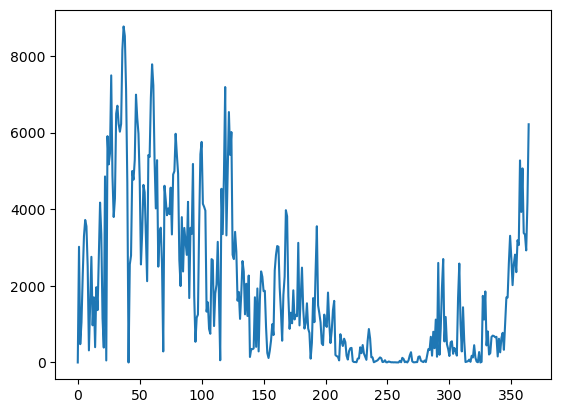

In [68]:
plt.plot(day_list)

In [69]:
all_cent_list = []
all_time_list = []

In [70]:
for j in range(len(list_row)):
    cent_list = [list_row[j][i][1] for i in range(len(list_row[j]))]
    time_list = [list_row[j][i][0] for i in range(len(list_row[j]))]
    all_cent_list = all_cent_list + cent_list
    all_time_list = all_time_list + time_list

In [71]:
if ipi_flag:
    ipi_list = analysis.ipi(all_time_list=all_time_list, sec=45)

In [72]:
os.makedirs(f'{workdirectory}/analysis', exist_ok=True)
if 'ipi_list.txt' not in os.listdir(f'{workdirectory}/analysis'):
    with open(f'{workdirectory}/analysis/ipi_list.txt', 'wb') as f:
        pickle.dump(ipi_list, f)

In [73]:
with open(f'{workdirectory}/analysis/ipi_list.txt', 'rb') as f:
    ipi_row = pickle.load(f)

In [74]:
s_ipi_list = [i/sr for i in ipi_row]

In [75]:
len(ipi_row)

642650

In [76]:
s_ipi_list.sort()

Text(0, 0.5, 'num')

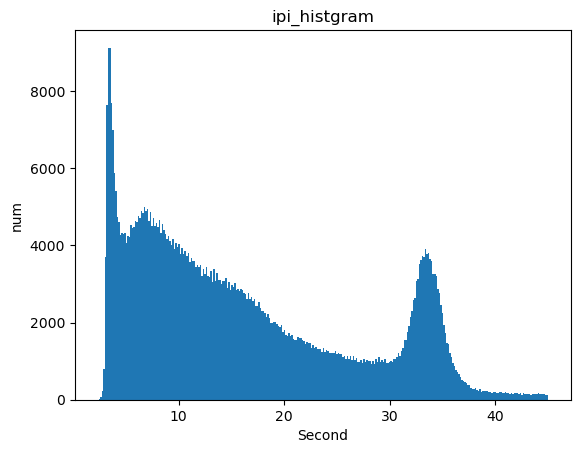

In [78]:
plt.hist(s_ipi_list, bins=300)
plt.title('ipi_histgram')
plt.xlabel('Second')
plt.ylabel('num')

In [79]:
all_cent_list.sort()

In [80]:
len(all_cent_list)

707492

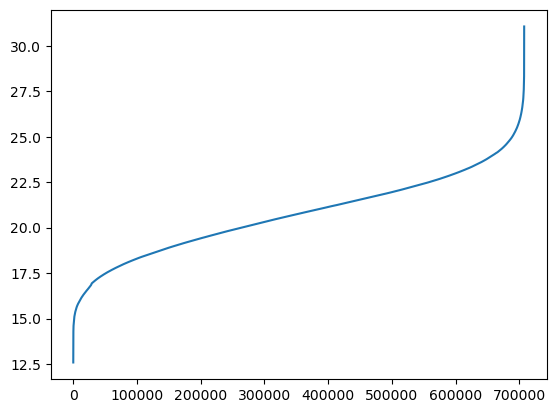

In [81]:
plt.plot(all_cent_list)

In [82]:
al = list(map(float, all_cent_list))
ar = [round(i, 1) for i in al]

Text(0, 0.5, 'num')

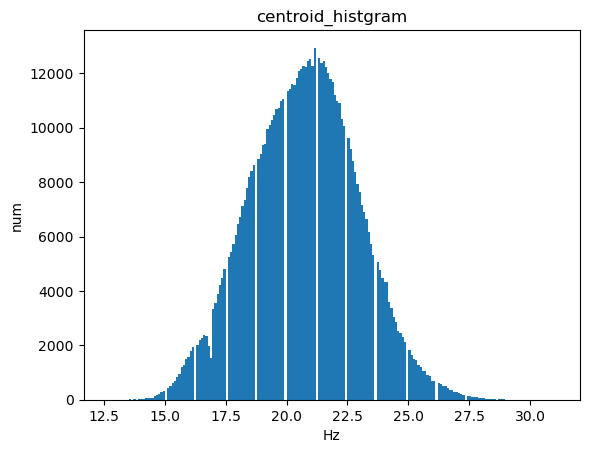

In [84]:
plt.hist(ar, bins=200)
plt.title('centroid_histgram')
plt.xlabel('Hz')
plt.ylabel('num')

#---------------------------------------------------------------------------------------------------#

<h2>k平均法で画像を自動分類</h2> 

In [85]:
cluster = wh.Clustering(workdirectory=workdirectory, datadirectory=datadirectory, sr=sr, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax, fpass=fpass, fstop=fstop, gpass=gpass, gstop=gstop, num_train=num_train, num_guard=num_guard, rate_fa=rate_fa)

In [86]:
if cluster_fig:
    %matplotlib notebook
    cluster_number = 8
    picked = spec.get_sp_wav(filelist=filelist)

In [87]:
if clustering:
    cluster.cluster_qw_sent(conv_dir=f'{workdirectory}/cfar/all/sep_fig/call', cluster_number=cluster_number)

In [88]:
if clustering:
    cluster.cluster_analysis(sr=sr)

In [89]:
if cluster_fig:
    for i in os.listdir(f'{workdirectory}/cfar/all/group_sum'):
        a = np.load(f'{workdirectory}/cfar/all/group_sum/{i}',allow_pickle=True)
        x = np.arange(len(a[0]))
        y = np.arange(len(a))
        X,Y=np.meshgrid(x,y)

        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.plot_surface(X, Y, a)

        ax.set_title(f'{i}')

        ax.set_xlabel('hour')
        ax.set_ylabel('date')
        ax.set_zlabel('n_call')

In [90]:
if clustering:
    cluster.all_3d_graph(sr=sr)

In [91]:
if cluster_fig:
    a = np.load(f'{workdirectory}/cfar/all/all.npy',allow_pickle=True)
    x = np.arange(len(a[0]))
    y = np.arange(len(a))
    X,Y=np.meshgrid(x,y)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, a)

    ax.set_title('all')

    ax.set_xlabel('hour')
    ax.set_ylabel('date')
    ax.set_zlabel('n_call')

In [92]:
%matplotlib inline

In [93]:
if cent_sep_flag:
    cluster.run_sep_cent(filelist=filelist)

In [94]:
os.makedirs(f'{workdirectory}/centroid/sep', exist_ok=True)


KeyboardInterrupt



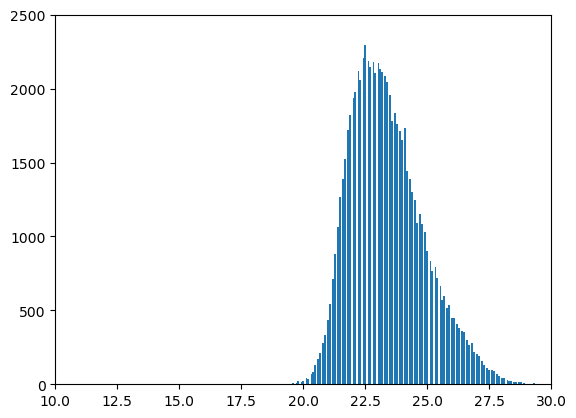

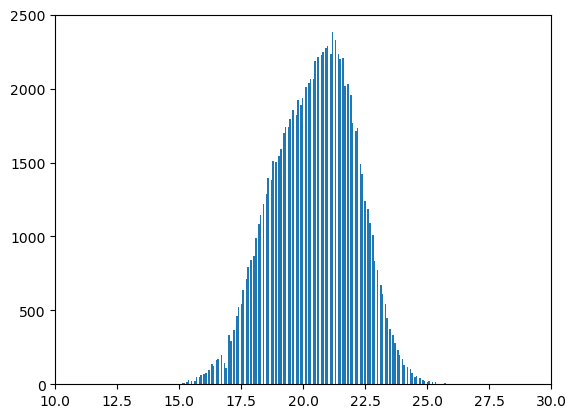

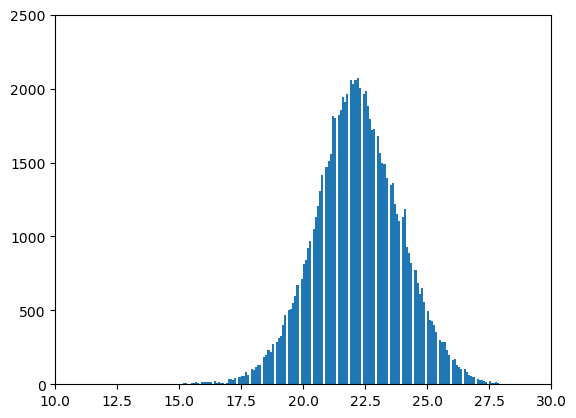

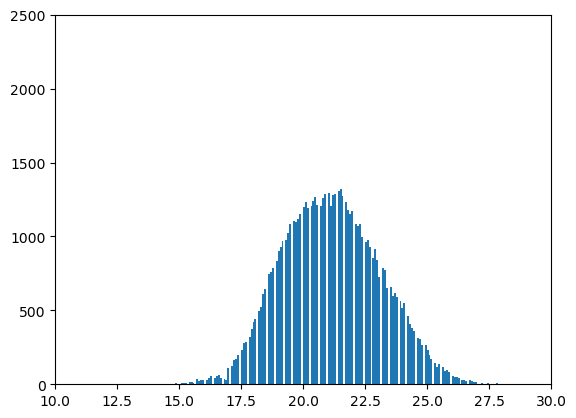

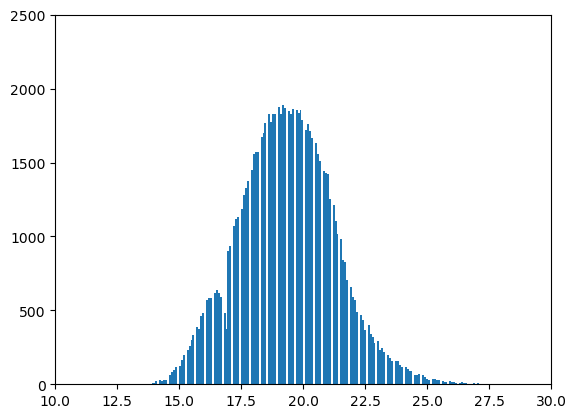

In [95]:
group_list = os.listdir(f'{workdirectory}/cfar/all/fig_group')
for path in group_list:
    cent_list = []
    with open(f'{workdirectory}/analysis/sep/cent_{path}.txt', 'rb') as f:
        cent_list = pickle.load(f)
    all_cent_list = []
    for j in range(len(cent_list)):
        cent_sep_list = [cent_list[j][i][1] for i in range(len(cent_list[j]))]
        all_cent_list = all_cent_list + cent_sep_list
    al = list(map(float, all_cent_list))
    ar = [round(i, 1) for i in al]
    fig = plt.figure()
    plt.hist(ar, bins=200)
    plt.xlim(10,30)
    plt.ylim(0,2500)
    plt.savefig(f'{workdirectory}/centroid/sep/{path}.jpg')